# McNemar's Test

McNemar’s test can be used when we need to compare the performance of two classifiers when we have matched pairs. The test works well if there are many different predictions between the two classifiers A and B.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import estimator_html_repr

from tqdm.notebook import tqdm
from IPython.core.display import HTML

## Loading the Data

In [2]:
df = pd.read_csv('../input/spaceship-titanic/train.csv')
print(df.shape)
df.head()

(8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
X_test = pd.read_csv('../input/spaceship-titanic/test.csv')

X = df.drop('Transported', axis=1)
y = df['Transported'].astype(int)

## Building the Model

In [4]:
# Some helper functions for feature extraction

def get_deck_and_side(df):
    return np.array([[x.split('/')[0], x.split('/')[2]] for x in np.ravel(df)])

def get_2d_to_1d(df):
    return df.reshape(-1)


# Preprocessing Components
comp_1_fn= lambda :Pipeline([
    ('imputer', SimpleImputer(strategy='median')), ('normalizer', StandardScaler())
])
comp_2_fn = lambda: Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('normalizer', OneHotEncoder(sparse=False, drop='if_binary'))
])
comp_3_fn = lambda: Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('normalizer', OneHotEncoder())
])
comp_4_fn = lambda: Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='//')), 
    ('function', FunctionTransformer(get_deck_and_side)),
    ('normalizer', OneHotEncoder())
])
comp_5_fn = lambda: Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ("reshape", FunctionTransformer(get_2d_to_1d)),
    ('normalizer', TfidfVectorizer(analyzer='char', ngram_range=(2, 3)))
])

# Preprocessors
preprocessor_1_fn = lambda: ColumnTransformer([
    ("scaler", comp_1_fn(), ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']),
    ("bin_encoder", comp_2_fn(), ['CryoSleep', 'VIP']),
    ('ohe_encoder', comp_3_fn(), ['HomePlanet', 'Destination']),
])
preprocessor_2_fn = lambda: ColumnTransformer([
    ("scaler", comp_1_fn(), ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']),
    ("bin_encoder", comp_2_fn(), ['CryoSleep', 'VIP']),
    ('ohe_encoder', comp_3_fn(), ['HomePlanet', 'Destination']),
    ('deck', comp_4_fn(), ['Cabin']),
    ('side', comp_5_fn(), ['Name']),
])

# Learning Algorithm
estimator_fn = lambda: LogisticRegression(random_state=0, max_iter=100_000)

# Models
model_1_fn = lambda: Pipeline([('preprocessor', preprocessor_1_fn()), ('estimator', estimator_fn())])
model_2_fn = lambda: Pipeline([('preprocessor', preprocessor_2_fn()), ('estimator', estimator_fn())])

In [5]:
HTML(estimator_html_repr(model_1_fn()))

In [6]:
HTML(estimator_html_repr(model_2_fn()))

## Training Loop

In [7]:
def train_skf(model_fn):
    oof_preds = y.copy()
    scores = []
    preds = []

    for fold, (train_index, valid_index) in tqdm(enumerate(skf.split(X, y))):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        model = model_fn().fit(X_train, y_train)
        preds.append(model.predict_proba(X_test)[:, 1])
        oof_preds.iloc[valid_index] = model.predict_proba(X_valid)[:, 1]
        scores.append(model.score(X_valid, y_valid))
        
    preds = np.array(preds).mean(axis=0)
    
    return oof_preds, scores, preds

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=True)
oof_1, scores_1, preds_1 = train_skf(model_1_fn)
print('Model 1 Score:', np.mean(preds_1))
oof_2, scores_2, preds_2 = train_skf(model_2_fn)
print('Model 2 Score:', np.mean(preds_2))

0it [00:00, ?it/s]

Model 1 Score: 0.5047894388034709


0it [00:00, ?it/s]

Model 2 Score: 0.5067088921731265


# Comparing Using McNemar's Test

McNemar’s test is designed to focus mainly on the differences that there are between two classifiers, therefore on the cases that they predicted in a different way. So the first thing we need to do is to go and calculate the following values.

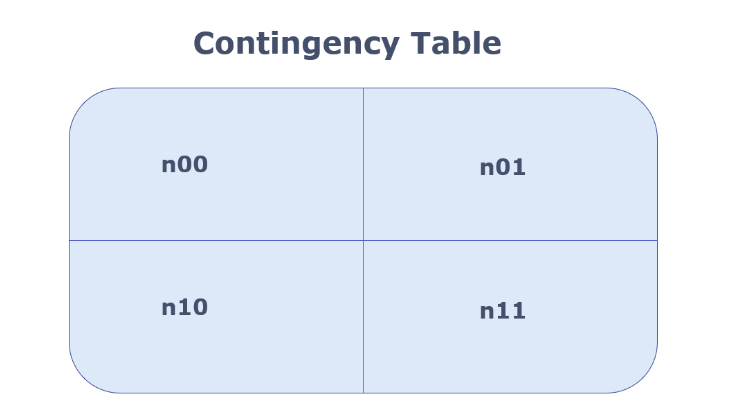

* n00: number of items misclassified by both A and B
* n01: number of items misclassified by A but not by B
* n10: number of items misclassified by B but not by A
* n11 : number of items classified correctly by both A and B

Null Hypotesis : n01 = n10, ie A and B have the same error rate.

McNemar’s test is basically a form of paired chi-square test, so next we need to compute X² value using the following formula.

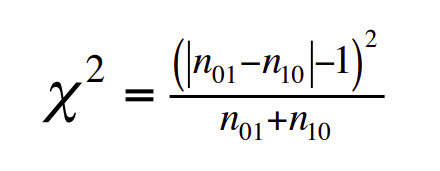

We can reject the null hypotesis if X² >X²(p) (in a two tailed test).
where p = level of significance

In [9]:
Y = pd.DataFrame(y.copy())
Y['model_1'] = np.where(oof_1 > 0.5, 1, 0)
Y['model_2'] = np.where(oof_2 > 0.5, 1, 0)
Y.head()

,Transported,model_1,model_2
0,0,1,1
1,1,0,0
2,0,0,0
3,0,0,0
4,1,0,0


In [10]:
from statsmodels.stats.contingency_tables import mcnemar

def get_contingency_table(Y, ground_truth, model_1, model_2):
    contingency_table = [[0, 0], [0, 0]]
    Y_ = Y.copy()
    model_1_correct = Y_.apply(lambda row: int(row[ground_truth] == row[model_1]), axis=1)
    model_2_correct = Y_.apply(lambda row: int(row[ground_truth] == row[model_2]), axis=1)
    contingency_table[0][0] = Y_.apply(
        lambda row: int(row[model_1] == 0 and row[model_2] == 0), axis=1
    ).sum()
    contingency_table[0][1] = Y_.apply(
        lambda row: int(row[model_1] == 0 and row[model_2] == 1), axis=1
    ).sum()
    contingency_table[1][0] = Y_.apply(
        lambda row: int(row[model_1] == 1 and row[model_2] == 0), axis=1
    ).sum()
    contingency_table[1][1] = Y_.apply(
        lambda row: int(row[model_1] == 1 and row[model_2] == 1), axis=1
    ).sum()
    return np.array(contingency_table)

def mcnemar_test(contigency_table, significance=0.05):
    print("Contigency Table")
    print(contigency_table)
    test = mcnemar(contigency_table, exact=False, correction=True)
    print("P value:", test.pvalue)
    if test.pvalue > significance:
        print("Reject Null Hypotheis")
        print("Conclusion: Model have statistically different error rate")
    else:
        print("Accept Null Hypotheis")
        print("Conclusion: Model do not have statistically different error rate")

mcnemar_test(get_contingency_table(Y, 'Transported', 'model_1', 'model_2'))

Contigency Table
[[3839  378]
 [ 324 4152]]
P value: 0.04546182590506626
Accept Null Hypotheis
Conclusion: Model do not have statistically different error rate
